## COINCIDE Data Exploration.

Data: Physiological signal captured in real-life conditions + PANAS-10 annotations + engagement data (notification time, response times, a tip of the day selected etc.)


In [1]:
import os
import re
import datetime
import zipfile
import numpy as np 
import pandas as pd
import heartpy as hp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
zip_data_path = "{0}/coincide.zip".format(os.getcwd())
extracted_data_path = '{0}/coincide'.format(os.getcwd())

In [3]:
with zipfile.ZipFile(zip_data_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_data_path)

### Participants

In [4]:
participants = os.listdir(extracted_data_path)

In [5]:
len(participants)

15

### Just in time responces (JIT)

JIT include:

- time of responce
- time spend at each question
- cognitive load self-estimated on the point of responce using 5 point Liker scale (where 0 is very low and 4 is very high)
- 10 emotions rated on 5 point Likert scale from Positive and Negative Affect Schedule (PANAS-10)


In [6]:
def jit_4_participant(participant):
    jit_folder = "{0}/{1}/jit_responses.csv".format(extracted_data_path, participant)
    df = pd.read_csv(jit_folder)
    df['TotalTimeSpent[ms]'] = df.apply(lambda row : np.sum([int(i) for i in re.findall(r'\d+',row['Times'])]), axis=1)
    return df

Example reading JIT for one participant

In [7]:
jit = jit_4_participant(participants[0])

In [8]:
jit[:3] # last 5 entries

,Times,Alert,CognitiveLoad,Inspired,Determined,Attentive,Hostile,Nervous,Upset,Afraid,Ashamed,Active,time,TotalTimeSpent[ms]
0,"[Decimal('2333'), Decimal('1469'), Decimal('13...",3,3,3,3,3,0,0,0,0,0,3,1.668582e+09,15182
1,"[Decimal('2261'), Decimal('1585'), Decimal('14...",3,3,3,3,3,0,0,0,0,0,0,1.668604e+09,20216
2,"[Decimal('2261'), Decimal('1585'), Decimal('14...",3,3,3,3,3,0,0,0,0,0,0,1.668604e+09,20216


In PANAS 
- Positive: Active, Inspired, Attentive, Determined and Alert
- Negative: Hostile, Nervous, Upset, Afraid and Ashamed

The scores for Positive emotions are summed togather and socres for Negative together to obtain two scores in range from 0-20. 

### Blood volume pulse data captured from samsung watch (PPG green LED)


In [9]:
def bvp_4_participant(participant):
    ppg_folder = "{0}/{1}/ppg_green.csv".format(extracted_data_path, participant)
    raw_signal = pd.read_csv(ppg_folder).rename(columns={"Unnamed: 0": "samples"})
    return raw_signal

In [10]:
raw_signal  = bvp_4_participant(participants[0]) # This is signal captured during the full study (10-14 days)

Lets try to find signal around jit responce for our participant

In [11]:
jit[:5]

,Times,Alert,CognitiveLoad,Inspired,Determined,Attentive,Hostile,Nervous,Upset,Afraid,Ashamed,Active,time,TotalTimeSpent[ms]
0,"[Decimal('2333'), Decimal('1469'), Decimal('13...",3,3,3,3,3,0,0,0,0,0,3,1.668582e+09,15182
1,"[Decimal('2261'), Decimal('1585'), Decimal('14...",3,3,3,3,3,0,0,0,0,0,0,1.668604e+09,20216
2,"[Decimal('2261'), Decimal('1585'), Decimal('14...",3,3,3,3,3,0,0,0,0,0,0,1.668604e+09,20216
3,"[Decimal('79110'), Decimal('2753'), Decimal('2...",2,2,2,1,2,0,0,0,0,0,1,1.668835e+09,115923
4,"[Decimal('4455'), Decimal('1766'), Decimal('15...",2,2,2,2,2,0,0,0,0,0,0,1.668839e+09,18509


In [12]:
seconds_before_and_after_responce = 15 *1 # lets consider some short extra time before and after annotating signal 

In [13]:
response_num = 1
jit['time'][response_num] 

1668603803.0

In [14]:
start = jit['time'][response_num] - seconds_before_and_after_responce
stop = (jit['time'][response_num]  + jit['TotalTimeSpent[ms]'][response_num]/1000) + seconds_before_and_after_responce

In [15]:
start, stop

(1668603788.0, 1668603838.216)

In [16]:
signal_within_timeframe = raw_signal[raw_signal['time'].between(start, stop, inclusive=True)]

In [17]:
signal_within_timeframe

,samples,PPG GREEN,time
16621,121,2033730.0,1.668604e+09
16622,122,2033233.0,1.668604e+09
16623,123,2031278.0,1.668604e+09
16624,124,2027681.0,1.668604e+09
16625,125,2024282.0,1.668604e+09
...,...,...,...
17395,895,1850765.0,1.668604e+09
17396,896,1850676.0,1.668604e+09
17397,897,1850650.0,1.668604e+09
17398,898,1849800.0,1.668604e+09


In [18]:
sampling_rate = len(signal_within_timeframe)/(signal_within_timeframe['time'].values[-1]-signal_within_timeframe['time'].values[0])

In [19]:
sampling_rate

24.95754988224965

In [20]:
filtered_highpass = hp.filtering.filter_signal(signal_within_timeframe['PPG GREEN'].values, cutoff=[0.7, 3.5],
                                                           filtertype='bandpass',
                                                           sample_rate=sampling_rate,
                                                           order=3, return_top=False)

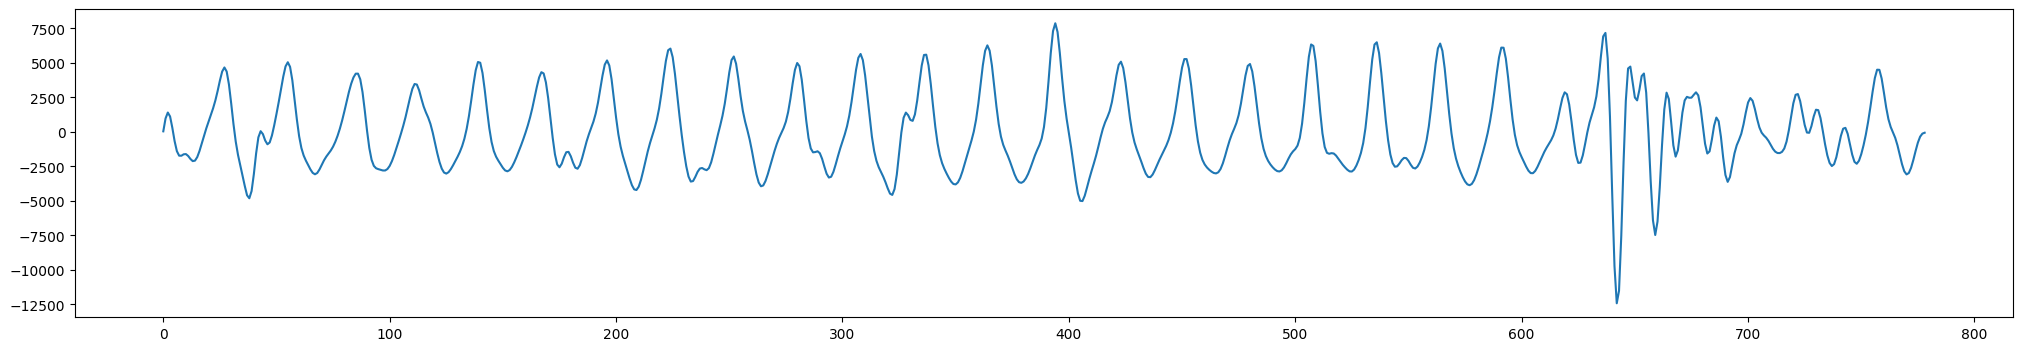

In [21]:
plt.figure(figsize=(25, 4))
plt.plot(filtered_highpass)
plt.show()

In [22]:
wd, m = hp.process(filtered_highpass, sampling_rate)
dfm = pd.DataFrame.from_dict(m, orient='index', columns=[response_num])

In [23]:
dfm.T

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
1,55.461222,1081.836964,114.159783,101.383745,118.653021,0.692308,0.230769,0.0,81.020277,79.001872,20108.560445,1.025549,0.326495


Example of sdding extracted HRV features anlongside jit annotations

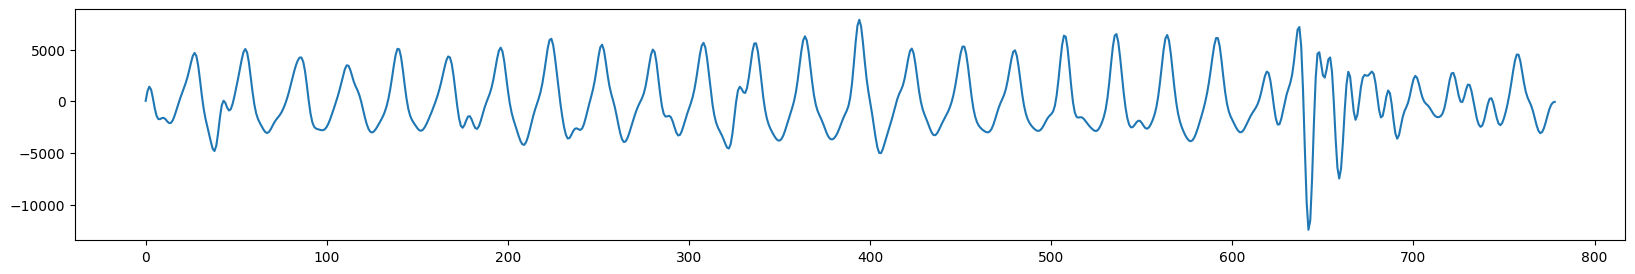

Signal has insufficient quality to extract features


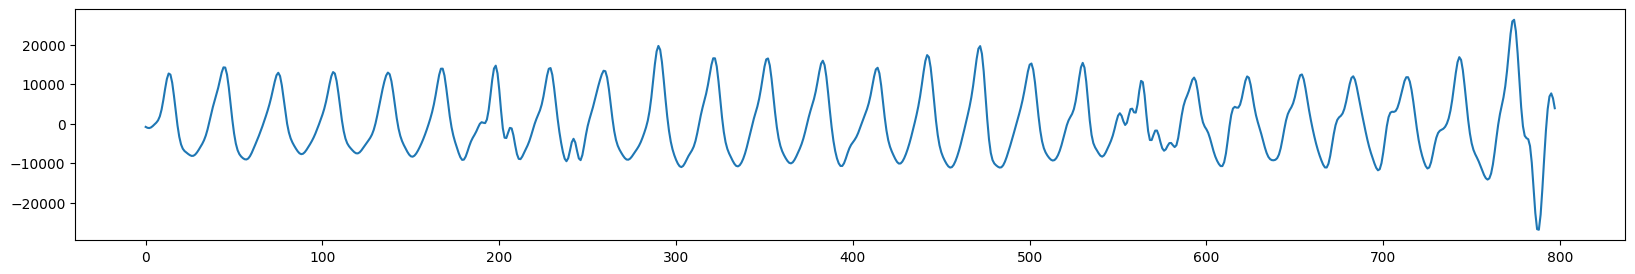

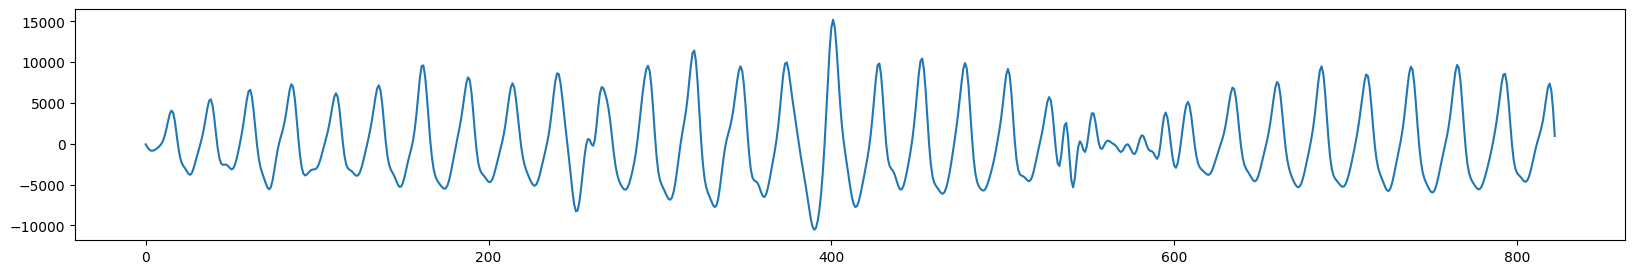

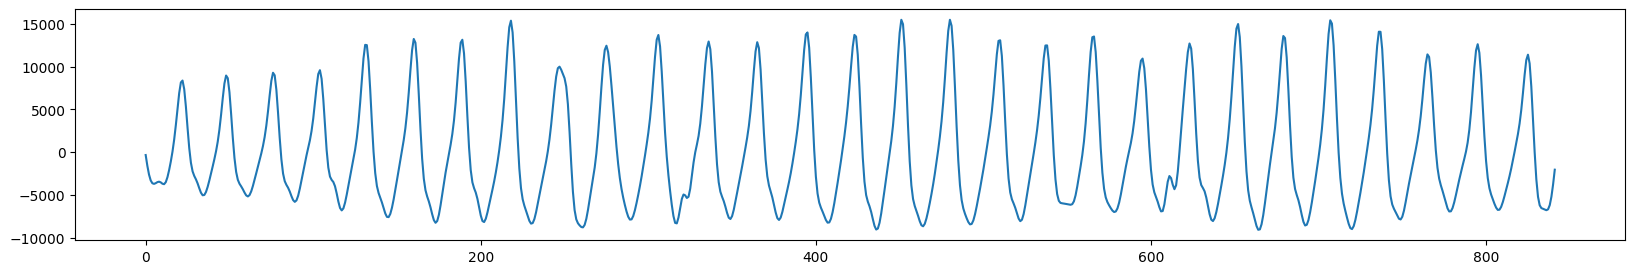

In [24]:
feature_list = []
for response_num in range(0,8):
    start = jit['time'][response_num] - seconds_before_and_after_responce
    stop = (jit['time'][response_num]  + jit['TotalTimeSpent[ms]'][response_num]/1000) + seconds_before_and_after_responce
    signal_within_timeframe = raw_signal[raw_signal['time'].between(start, stop, inclusive=True)]
    if len(signal_within_timeframe)> 0:
        sampling_rate = len(signal_within_timeframe)/(signal_within_timeframe['time'].values[-1]-signal_within_timeframe['time'].values[0])
        filtered_highpass = hp.filtering.filter_signal(signal_within_timeframe['PPG GREEN'].values, cutoff=[0.7, 3.5],
                                                           filtertype='bandpass',
                                                           sample_rate=sampling_rate,
                                                           order=3, return_top=False)
        
        # print(jit[['Alert', 'CognitiveLoad', 'Inspired', 'Determined','Attentive', 'Hostile', 'Nervous', 'Upset', 'Afraid', 'Ashamed','Active']].iloc[response_num])
        try:
            wd, m = hp.process(filtered_highpass, sampling_rate)
            dfm = pd.DataFrame.from_dict(m, orient='index', columns=[response_num])
            # print(dfm.T)
            feature_list.append(dfm.T)
            plt.figure(figsize=(20, 3))
            plt.plot(filtered_highpass)
            plt.show()
        except:
            print("Signal has insufficient quality to extract features")


In [25]:
features_for_response= pd.concat(feature_list, axis=0)

In [26]:
features_for_response

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
1,55.461222,1081.836964,114.159783,101.383745,118.653021,0.692308,0.230769,0.000000,81.020277,79.001872,20108.560445,1.025549,0.326495
5,49.181738,1219.965017,40.996954,46.157063,63.368399,0.583333,0.333333,0.000000,44.808225,38.079669,5360.444052,1.176697,0.300000
6,58.073226,1033.178347,51.551310,28.340977,34.710467,0.375000,0.125000,40.080194,24.430112,60.628425,4653.198951,0.402948,0.107565
7,52.203112,1149.356757,42.915992,31.766277,49.985047,0.703704,0.222222,40.077197,35.094534,45.144458,4977.299721,0.777383,0.266667


In [27]:
jit_with_hrv_features = pd.concat([jit, features_for_responce], axis=1)

In [28]:
jit_with_hrv_features[:8]

,Times,Alert,CognitiveLoad,Inspired,Determined,Attentive,Hostile,Nervous,Upset,Afraid,...,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,"[Decimal('2333'), Decimal('1469'), Decimal('13...",3,3,3,3,3,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Decimal('2261'), Decimal('1585'), Decimal('14...",3,3,3,3,3,0,0,0,0,...,101.383745,118.653021,0.692308,0.230769,0.000000,81.020277,79.001872,20108.560445,1.025549,0.326495
2,"[Decimal('2261'), Decimal('1585'), Decimal('14...",3,3,3,3,3,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[Decimal('79110'), Decimal('2753'), Decimal('2...",2,2,2,1,2,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[Decimal('4455'), Decimal('1766'), Decimal('15...",2,2,2,2,2,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"[Decimal('4369'), Decimal('1639'), Decimal('17...",3,3,3,3,4,0,0,0,0,...,46.157063,63.368399,0.583333,0.333333,0.000000,44.808225,38.079669,5360.444052,1.176697,0.300000
6,"[Decimal('3655'), Decimal('1554'), Decimal('20...",3,3,2,3,3,0,0,0,0,...,28.340977,34.710467,0.375000,0.125000,40.080194,24.430112,60.628425,4653.198951,0.402948,0.107565
7,"[Decimal('2192'), Decimal('1765'), Decimal('20...",2,3,1,2,2,0,0,0,0,...,31.766277,49.985047,0.703704,0.222222,40.077197,35.094534,45.144458,4977.299721,0.777383,0.266667


Note that not for all annotations there was sufficient quality signal captured to extract HRV features

### Engagment 

In [29]:
def engagement_4_participant(participant):
    engagement_folder = "{0}/{1}/engagement.csv".format(extracted_data_path, participant)
    engagement_data = pd.read_csv(engagement_folder)
    return engagement_data

In [30]:
engagement = engagement_4_participant(participants[0])

In [31]:
engagement[20:]

,EventType,Device,DailyTipId,DailyTipType,DailyTipLink,time
20,DAILY_TIP_LINK_PRESSED_de55771c-e98d-4623-a781...,SMARTPHONE,6,FOCUS,https://www.sciencedirect.com/science/article/...,1.668858e+09
21,DAILY_TIP_LINK_PRESSED_34e6fafd-6e62-471d-9f0d...,SMARTPHONE,6,FOCUS,https://www.amazon.de/-/en/Winifred-Gallagher/...,1.668858e+09
22,DAILY_TIP_LINK_PRESSED_a7e33b38-10a6-4811-9330...,SMARTPHONE,6,FOCUS,https://www.amazon.de/-/en/Winifred-Gallagher/...,1.668858e+09
23,APP_OPEN_dc1295cd-e0d4-49f7-944e-9168f3f7f710,SMARTPHONE,0,NaN,NaN,1.668862e+09
24,APP_OPEN_acbf8414-c205-4723-bf98-28cdd295c3eb,SMARTPHONE,0,NaN,NaN,1.668863e+09
...,...,...,...,...,...,...
191,APP_OPEN_d55fffb2-7827-4af7-9f37-43150e1a1963,SMARTPHONE,0,NaN,NaN,1.670218e+09
192,APP_OPEN_0baf5dc8-c1af-435f-b0f6-7250de8f85b9,SMARTPHONE,0,NaN,NaN,1.670218e+09
193,APP_OPEN_e3ba156c-e556-4f5d-ad04-f730f2f42545,WEARABLE,0,NaN,NaN,1.670218e+09
194,NOTIFICATION_SENT_99d7bab8-b8c9-422d-905e-f952...,WEARABLE,0,NaN,NaN,1.670219e+09


In [32]:
notifications = engagement[engagement['EventType'].str.contains('NOTIFICATION_SENT')]